In [1]:
! pip install --upgrade --quiet  wikipedia

In [2]:
! pip install -U langchain langchain-openai

In [3]:
! pip install langgraph langchain_community

In [4]:

import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "pr-tart-safeguard-1"


In [5]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [6]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END


In [8]:
from langchain_groq import ChatGroq


In [9]:
import getpass
import os

os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

In [10]:
llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [11]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [12]:
graph_builder = StateGraph(State)


In [13]:
llm_with_tools = llm.bind_tools([wikipedia])


In [14]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


In [15]:
graph_builder.add_node("chatbot", chatbot)


In [16]:
tool_node = ToolNode(tools=[wikipedia])


In [17]:
graph_builder.add_node("tools", tool_node)


In [18]:
graph_builder.add_edge(START, "chatbot") 


In [19]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,  
)

In [20]:
graph_builder.add_edge("tools", "chatbot")  


In [21]:
graph_builder.add_edge("chatbot", END)  


In [22]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [23]:
graph = graph_builder.compile(checkpointer=memory)

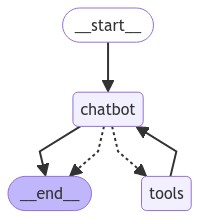

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [25]:
config = {"configurable": {"thread_id": "1"}}

In [26]:
user_input = "Hi there! My name is Will."

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! It's nice to meet you. Is there a specific question or topic you'd like me to help you with? If not, I can provide general information on various subjects.

If you need help with something specific, please feel free to ask! I'm here to assist you in any way I can.


In [27]:
user_input = "Remember my name?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, of course! You mentioned earlier that your name is Will. I'm designed to remember the context of our conversation. How can I help you today, Will? Is there something you'd like to know or discuss? I'm here to provide information and support.
